## Concept

* uses data from the same input variable in a lagged format (residuals)

* $ y_t = c + \phi_1 e_{t-1} + .. + \phi_p e_{t-p} + \epsilon_t $

* Variables:
    * $\epsilon$ - irreducible error (white noise)
    * $\phi$ - coefficient
    * p - order
    * e - residuals upto that particular order
    
## Prepare Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

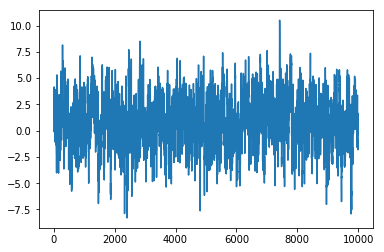

In [2]:
df = pd.read_excel(r'../data/ts_data.xlsx')
plt.plot(df.Value)

## Linear Regression Approach

In [8]:
# Build Linear Regression -> Generate Residuals -> Build LR with Residuals as predictors

df['y'] = df['Value'].shift(1)
df = df.dropna(axis = 0)

train_size = int(len(df)*0.80)
xtrain, ytrain = df['Value'][0:train_size].values, df['y'][0:train_size].values
xtest, ytest = df['Value'][train_size:].values, df['y'][train_size:].values

xtrain = xtrain.reshape(-1, 1)
xtest = xtest.reshape(-1, 1)

lr_model = LinearRegression()
lr_model.fit(xtrain, ytrain)
ytest_lr_forecast = lr_model.predict(xtest)
ytrain_lr_forecast = lr_model.predict(xtrain)

# MA model is with residuals
residual_train = ytrain - ytrain_lr_forecast
lr_model = LinearRegression()
lr_model.fit(residual_train.reshape(-1, 1), ytrain)
print(f"intercept : {lr_model.intercept_}, coeff : {lr_model.coef_[0]}")

# get predictions
residual_test = ytest - ytest_lr_forecast
ytest_lr_forecast = lr_model.predict(residual_test.reshape(-1, 1))

intercept : 0.7244216061221025, coeff : 0.9999999999999989


## Build MA Model

In [35]:
# Build MA model
ma_model = ARIMA(ytrain, order = (0, 0, 1))
ma_model_fit = ma_model.fit()

print(f"lr intercept : {lr_model.intercept_}, lr coeff : {lr_model.coef_[0]}")
print(ma_model_fit.summary())

# get predictions/forecast
ytest_ma_forecast = ma_model_fit.forecast(len(ytest))

lr intercept : 0.7244216061221025, lr coeff : 0.9999999999999989
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 7996
Model:                     ARMA(0, 1)   Log Likelihood              -14899.355
Method:                       css-mle   S.D. of innovations              1.559
Date:                Mon, 13 Sep 2021   AIC                          29804.710
Time:                        22:45:29   BIC                          29825.670
Sample:                             0   HQIC                         29811.885
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7245      0.030     23.837      0.000       0.665       0.784
ma.L1.y        0.7429      0.006    132.420      0.000       0.732

C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


## Compare Results

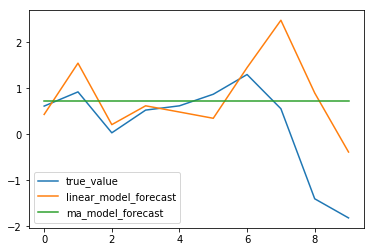

In [37]:
plt.plot(ytest[-10:], label = 'true_value')
plt.plot(ytest_lr_forecast[-10:], label = 'linear_model_forecast')
plt.plot(ytest_ma_forecast[0][-10:], label = 'ma_model_forecast')

plt.legend()

## Compare against rolling window MA forecast

C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


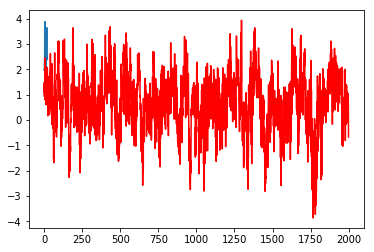

In [32]:
rolling_history = [x for x in ytrain]
predictions = []
for t in range(len(ytest)):
    model = ARIMA(rolling_history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = ytest[t]
    rolling_history.append(obs)

# plot forecasts against actual outcomes
plt.plot(ytest)
plt.plot(predictions, color='red')
plt.show()

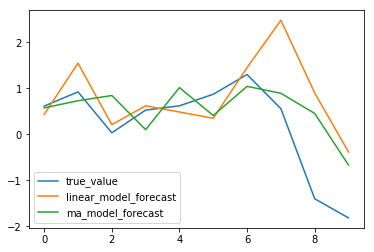

In [33]:
plt.plot(ytest[-10:], label = 'true_value')
plt.plot(ytest_lr_forecast[-10:], label = 'linear_model_forecast')
plt.plot(predictions[-10:], label = 'ma_model_forecast')
plt.legend()